In [95]:
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import matplotlib.pyplot as plt
import numpy as np

In [96]:
# функция, реализующая обратное преобразование Бокса-Кокса

def my_inv_boxcox(y, lmbda):
    if lmbda == 0:
        result = (np.exp(y))
    else:
        result = (np.exp(np.log(lmbda*y+1)/lmbda))
    return result

In [97]:
# обновленная версия датасета с данными по сентябрь 2021 включительно

data = pd.read_csv('updated_WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'],
                   dayfirst=True)

In [101]:
data

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,WAG_C_M,WAG_C_M_boxcox
month,,
1993-01-01,15.3,4.205723
1993-02-01,19.1,4.721882
1993-03-01,23.6,5.246889
1993-04-01,30.6,5.938356
1993-05-01,37.5,6.518187
...,...,...
2021-05-01,56171.0,83.577467
2021-06-01,58782.0,84.760270
2021-07-01,55170.0,83.113760


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Средняя номинальная заработная плата')

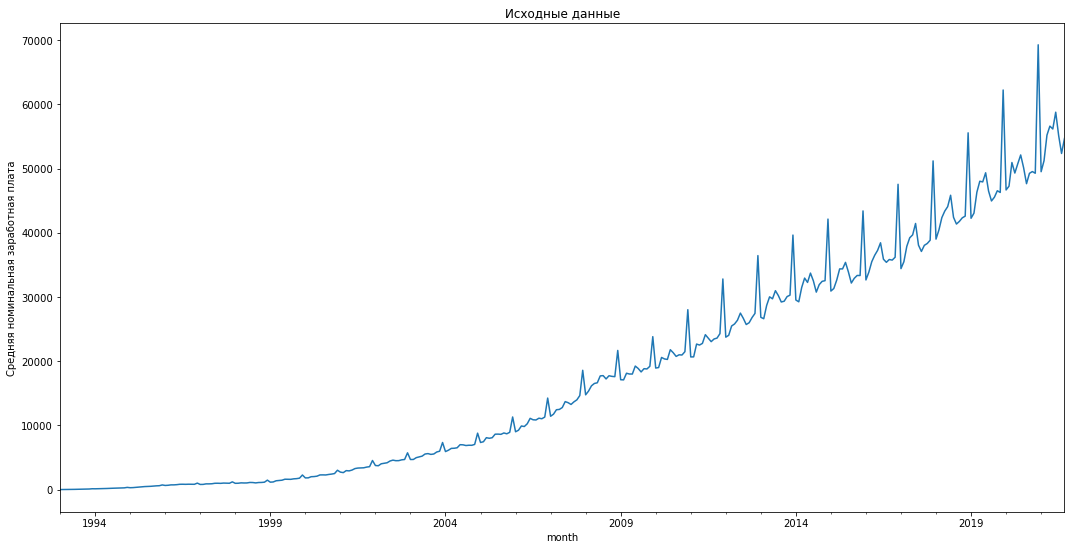

In [102]:
# ПУНКТ ПЕРВЫЙ - визульный анализ ряда.
# налицо и тренд, и сезонность, и увеличение дисперсии

plt.figure(figsize=(18,9))
data['WAG_C_M'].plot()
plt.title('Исходные данные')
plt.ylabel('Средняя номинальная заработная плата')

Оптимальный параметр преобразования Бокса-Кокса:
	 λ =  0.297417 



C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


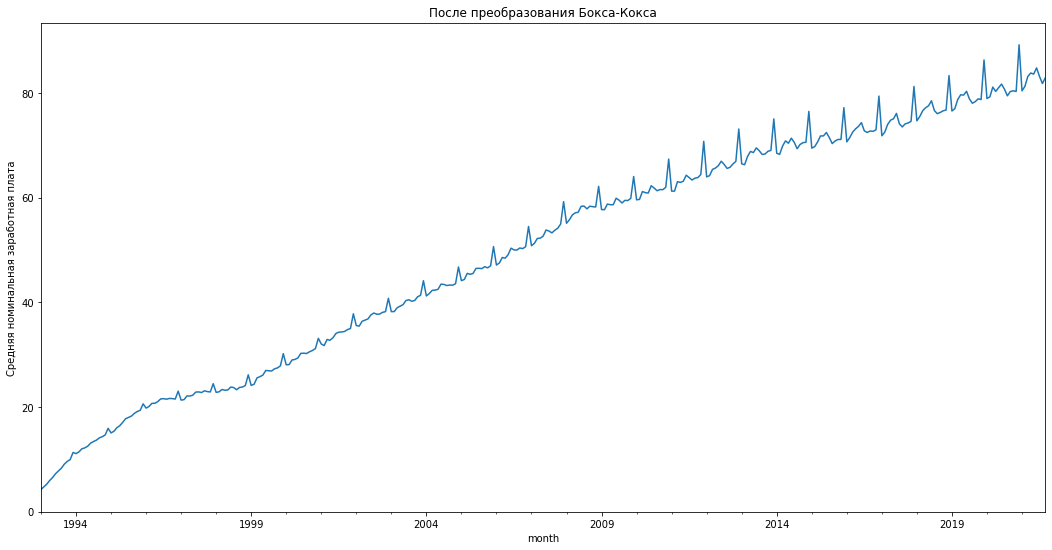

In [103]:
# ПУНКТ ВТОРОЙ - стабилизация дисперсии (при необходимости)
# исходя из визуальной оценки мы видим, что дисперсию нужно стабилизировать. Воспользуемся для этого преобразованием Бокса-Кокса

data['WAG_C_M_boxcox'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize=(18,9))
data.WAG_C_M_boxcox.plot()
plt.title('После преобразования Бокса-Кокса')
plt.ylabel('Средняя номинальная заработная плата')

print('Оптимальный параметр преобразования Бокса-Кокса:')
print('\t \u03bb = ', round(lmbda, 6), '\n')

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


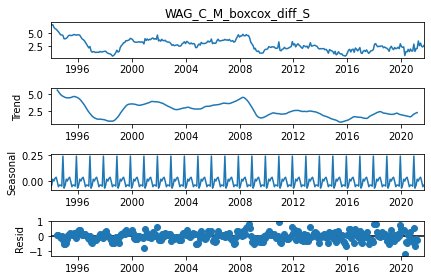

In [104]:
# ПУНКТ ТРЕТИЙ - выбор порядка дифференцирования
# преобразование Бокса-Кокса ожидаемо не избавило нас от тренда и сезонности. Чтобы сделать ряд стационарным, 
# попробуем его дифференцировать. Начнём с сезонного дифференцирования

S = 12 # длительность сезона (12 месяцев)
data['WAG_C_M_boxcox_diff_S'] = data.WAG_C_M_boxcox - data.WAG_C_M_boxcox.shift(S)
sm.tsa.seasonal_decompose(data.WAG_C_M_boxcox_diff_S[S:]).plot()
plt.show()

In [105]:
# оценивать стационарность ряда будем при помощи критерия Дики-Фуллера

print('\tp-value = ', round(sm.tsa.stattools.adfuller(data.WAG_C_M_boxcox_diff_S[S:])[1], 6))

# согласно критерию ряд не станционарный да и визуально отчётливо виден тренд

	p-value =  0.108466


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


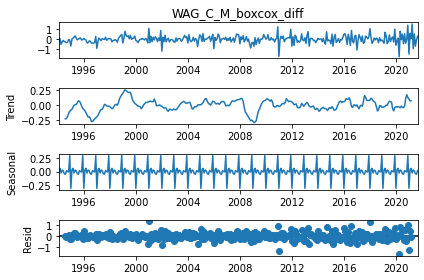

In [106]:
# чтобы всё-таки избавиться от тренда, попробуем ещё раз продифференцировать наш ряд, но уже не по сезонам

data['WAG_C_M_boxcox_diff'] = data.WAG_C_M_boxcox_diff_S - data.WAG_C_M_boxcox_diff_S.shift(1)
sm.tsa.seasonal_decompose(data.WAG_C_M_boxcox_diff[(S+1):]).plot()
plt.show()

In [107]:
# снова оцениваем стационарность ряда при помощи критерия Дики-Фуллера

print('\tp-value = ', round(sm.tsa.stattools.adfuller(data.WAG_C_M_boxcox_diff[(S+1):])[1], 6))

# гипотеза о нестационарности уверенно отвергается, тренд и остатки выглядят шумоподобно

	p-value =  0.003349


In [108]:
# зафиксируем промежуточные итоги

D, d = 1, 1
print('Количество сезонных и обычных дифференцирований:')
print('\t D = ', D)
print('\t d = ', d)

Количество сезонных и обычных дифференцирований:
	 D =  1
	 d =  1


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q×S - номер последнего сезонного лага со значимой автокорреляцией
q - номер последнего несезонного лага со значимой автокорреляцией


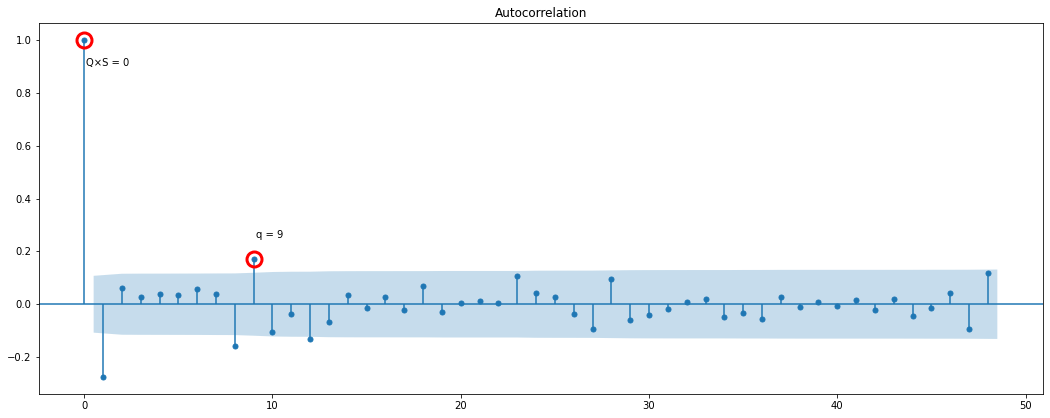

In [109]:
# ПУНКТ ЧЕТВЁРТЫЙ - выбор начальных приближений для p, q, P, Q
# начинаем с анализа автокорреляционной функции для отыскания q и Q


print('Q\u00d7S - номер последнего сезонного лага со значимой автокорреляцией')
print('q - номер последнего несезонного лага со значимой автокорреляцией')

plt.figure(figsize=(18,15))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(data.WAG_C_M_boxcox_diff[(S+1):].values.squeeze(), lags=4*S, ax=ax)
q, q_mark, q_text = 9, 0.17, 0.25
plt.plot(q, q_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(q+0.1, q_text, 'q = {}'.format(q))
Q, Q_mark, Q_text = 0, 1, 0.9
plt.plot(Q, Q_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(Q+0.1, Q_text, 'Q\u00d7S = {}'.format(Q))
Q = int(Q/S)

P×S - номер последнего сезонного лага со значимой частичной автокорреляцией
p - номер последнего несезонного лага со значимой автокорреляцией


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


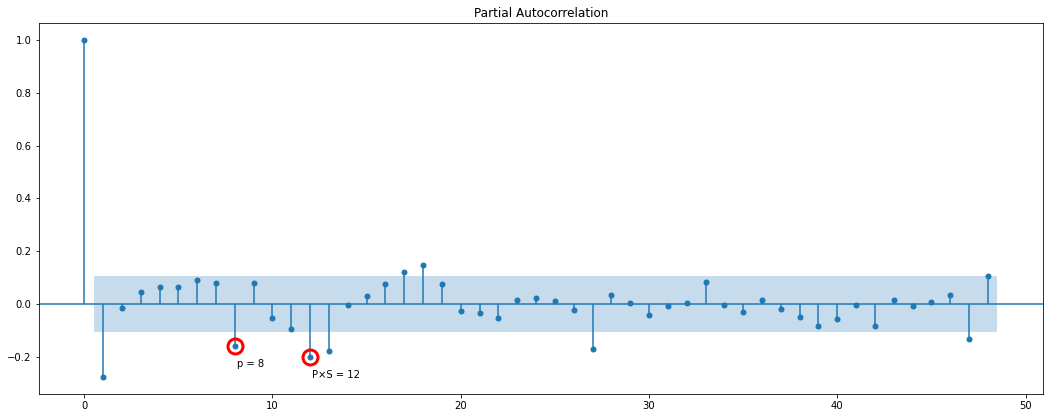

In [110]:
# теперь приступаем к анализу частичной автокорреляционной функции для отыскания p и P

print('P\u00d7S - номер последнего сезонного лага со значимой частичной автокорреляцией')
print('p - номер последнего несезонного лага со значимой автокорреляцией')

plt.figure(figsize=(18,15))
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_boxcox_diff[(S+1):].values.squeeze(), lags=4*S, ax=ax)
p, p_mark, p_text = 8, -0.16, -0.24
plt.plot(p, p_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(p+0.1, p_text, 'p = {}'.format(p))
P, P_mark, P_text = 12, -0.2, -0.28
plt.plot(P, P_mark, marker='o', markerfacecolor=(1,1,0,0), markeredgecolor='r', markeredgewidth=3, markersize=15)
plt.text(P+0.1, P_text, 'P\u00d7S = {}'.format(P))
P = int(P/S)

In [111]:
# ещё раз зафиксируем промежуточные итоги

print('Начальные приближения из графика автокорреляционной функции:')
print('\t Q = ', Q)
print('\t q = ', q)

print('Начальные приближения из графика частичной автокорреляционной функции:')
print('\t P = ', P)
print('\t p = ', p, '\n')

Начальные приближения из графика автокорреляционной функции:
	 Q =  0
	 q =  9
Начальные приближения из графика частичной автокорреляционной функции:
	 P =  1
	 p =  8 



C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
# ПУНКТ ПЯТЫЙ - обучение и сравнение моделей-кандидатов, выбор победителя

# немного подготовительных действий

ps = range(p+1)
Ps = range(P+1)
qs = range(q+1)
Qs = range(Q+1)

parametrs = product(ps, qs, Ps, Qs)
parametrs_list = list(parametrs)
print('Количество моделей для перебора: ', len(parametrs_list), '\n')



Количество моделей для перебора:  180 



In [113]:
# собственно сам перебор

%%time

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for i, param in enumerate(parametrs_list):
    try:
        model = sm.tsa.statespace.SARIMAX(data.WAG_C_M_boxcox, order=(param[0], d, param[1]),
                                          seasonal_order=(param[2], D, param[3], S)).fit(disp=-1)
    except ValueError:
        print('Параметры невозможные для обучения: ', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

UsageError: Line magic function `%%time` not found.


In [70]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
55   (2, 7, 1, 0)  256.665192
59   (2, 9, 1, 0)  257.412352
171  (8, 5, 1, 0)  257.817828
57   (2, 8, 1, 0)  258.216745
99   (4, 9, 1, 0)  258.822627


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
best_model.summary()

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                      WAG_C_M_boxcox   No. Observations:                  345
Model:             SARIMAX(2, 1, 7)x(1, 1, [], 12)   Log Likelihood                -117.333
Date:                             Sat, 18 Dec 2021   AIC                            256.665
Time:                                     20:04:35   BIC                            298.522
Sample:                                 01-01-1993   HQIC                           273.358
                                      - 09-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1674      0.083    -14.010      0.000      -1.331      -1.004
ar.L2         -0.7938      0.078    -10.168      0.000      -0.947      -0.641
ma.L1          0.8257      0.098      8.425      0.000       0.634       1.018
ma.L2          0.4431      0.093      4.781      0.000       0.261       0.625
ma.L3         -0.1720      0.068     -2.530      0.011      -0.305      -0.039
ma.L4          0.1731      0.077      2.254      0.024       0.023       0.324
ma.L5          0.2219      0.074      2.998      0.003       0.077       0.367
ma.L6          0.3198      0.068      4.673      0.000       0.186       0.454
ma.L7          0.2633      0.058      4.546      0.000       0.150       0.377
ar.S.L12      -0.3245      0.044     -7.429      0.000      -0.410      -0.239
sigma2         0.1178      0.006     18.689      0.000       0.105       0.130
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               128.18
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


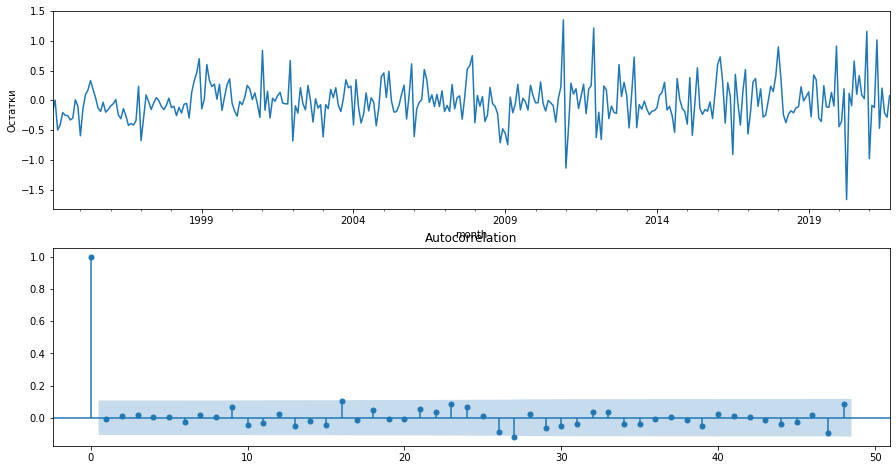

In [73]:
# ПУНКТ ШЕСТОЙ - анализ остатков построенной модели

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
best_model.resid[(S+1):].plot()
plt.ylabel('Остатки')

ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_acf(best_model.resid[(S+1):].values.squeeze(), lags=4*S, ax=ax)
plt.show()

In [74]:
print('Критерий Стьюдента для остатков модели:')
p_value = stats.ttest_1samp(best_model.resid[(S+1):], 0)[1]
print('\tp-value = ', round(p_value, 6))

# нулевая гипотеза о несмещенности остатков не отвергается

Критерий Стьюдента для остатков модели:
	p-value =  0.341599


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
print('Критерий Дики-Фуллера для остатков модели:')
p_value = sm.tsa.stattools.adfuller(best_model.resid[(S+1):])[1]
print('\tp-value = ', round(p_value, 6))

# нулевая гипотеза о нестационарности остатков отвергается

Критерий Дики-Фуллера для остатков модели:
	p-value =  0.0


C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


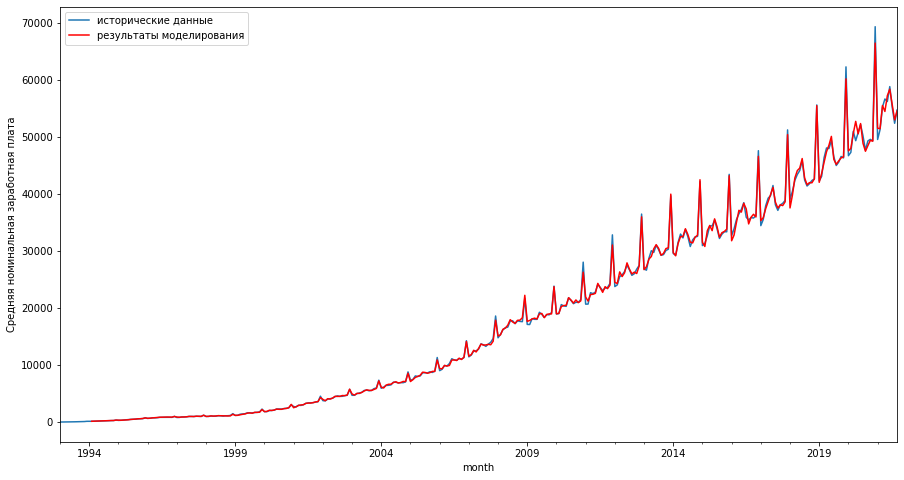

In [76]:
# ПУНКТ СЕДЬМОЙ - прогнозирование с помощью финальной модели
# проверка модели на известных данных

data['model'] = my_inv_boxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,8))
data.WAG_C_M.plot(label='исторические данные')
data.model[(S+1):].plot(color='r', label='результаты моделирования')
plt.ylabel('Средняя номинальная заработная плата')
plt.legend()
plt.show()

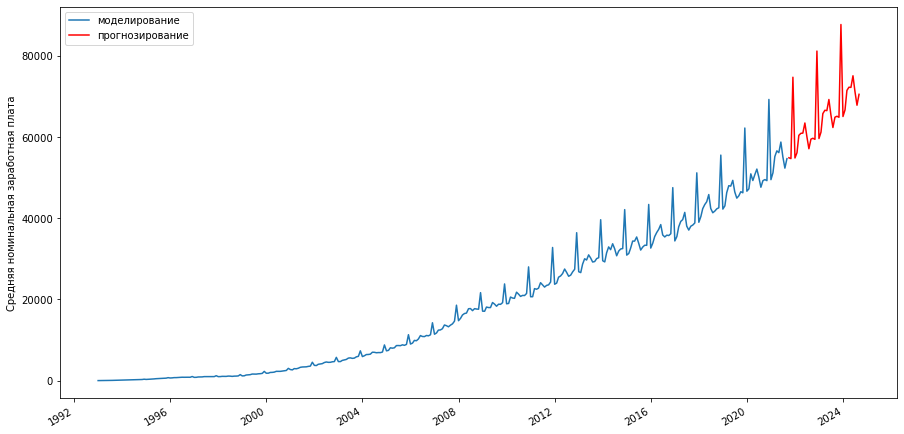

In [82]:
# прогнозирование значений при помощи построенной модели

future_distance = 3*12
Y = data.index[-1].year
M = data.index[-1].month
D = data.index[-1].day

data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime('{}-{}-{}'.format(Y, M, D),"%Y-%m-%d") + 
             relativedelta(year=2021+(8+x)//12, month=1+(8+x)%12) for x in range(future_distance+1)]

future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = my_inv_boxcox(best_model.predict(start=data.shape[0], end=data.shape[0]+50), lmbda)

plt.figure(figsize=(15,8))
data2.WAG_C_M.plot(label='моделирование')
data2.forecast.plot(color='r', label='прогнозирование')
plt.ylabel('Средняя номинальная заработная плата')
plt.legend()
plt.show()

# прогноз выглядит правдоподобно